In [1]:
import tensorflow as tf
from PIL import Image
import tensorflow_hub as hub
from torchvision import transforms
import numpy as np

### TensorFlow Hub  


In [ ]:
tensor_path = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/'

In [ ]:
tf_model_path = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/efficientnet_lite4_feature-vector_2'

In [ ]:
module_spec = hub.load_module_spec(tf_model_path)
height, width = hub.get_expected_image_size(module_spec)

In [ ]:
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(Image.open('/content/drive/MyDrive/Colab/Sketch_RNN_Together/Dataset/input/eye/eye_input_1.jpg').convert("RGB")).unsqueeze(0)
img = tf.reshape(img, [1, 224, 224, 3]) #[batch_size, height, width, 3]

In [ ]:
obj = hub.load(tf_model_path)
img = tf.reshape(img, [1, 224, 224, 3]) #[batch_size, height, width, 3]
obj.signatures['default'](img)

{'default': <tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
 array([[0.15732348, 0.01069743, 0.15781823, ..., 0.        , 0.03200955,
         0.33155206]], dtype=float32)>}

In [ ]:
feat = obj.signatures['default'](img)
feat.get('default').numpy()

array([[0.15732348, 0.01069743, 0.15781823, ..., 0.        , 0.03200955,
        0.33155206]], dtype=float32)

### TensorFlow Lite 모델에 메타 데이터 추가  
https://www.tensorflow.org/lite/convert/metadata#visualize_the_metadata

In [ ]:
!pip install tflite-support

     |████████████████████████████████| 1.1 MB 39.3 MB/s 
     |████████████████████████████████| 200 kB 64.6 MB/s 


In [ ]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Efficientnet Feature vector"
model_meta.description = ("Extract Feature")
model_meta.version = "v1"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [ ]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [ ]:
input_meta.name = "image"
input_meta.description = (
    "Input image".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization] b
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [ ]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "feature"
output_meta.description = "feature of image"
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [255]
output_stats.min = [0]
output_meta.stats = output_stats

In [ ]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [ ]:
populator = _metadata.MetadataPopulator.with_model_file('/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/tensorflow/effi_extractor.tflite')
populator.load_metadata_buffer(metadata_buf)
populator.populate()

### tflite Interpreter

In [ ]:
tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(Image.open('/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/test_set(random)/eye/test_eye_1.jpg').convert("RGB")).unsqueeze(0)
img = tf.reshape(img, [1, 224, 224, 3]) #[batch_size, height, width, 3]
img.shape

TensorShape([1, 224, 224, 3])

In [ ]:
output = tf.zeros([1, 1280])
output.shape

TensorShape([1, 1280])

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_efficientnetb0_input:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 487,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 1280], dtype=int32),
  'shape_signature': array([  -1, 1280], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/tensorflow/effi_extractor.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = img
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

### tflite Converter

In [ ]:
!saved_model_cli show --dir '/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/efficientnet_lite4_feature-vector_2/' --tag_set serve --signature_def serving_default

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 990, in main
    args.func(args)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 702, in show
    _show_inputs_outputs(args.dir, args.tag_set, args.signature_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_cli.py", line 137, in _show_inputs_outputs
    tag_set)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow_core/python/tools/saved_model_utils.py", line 120, in get_meta_graph_def
    ' could not be found in SavedModel')
RuntimeError: MetaGraphDef associated with tag-set serve could not be found in SavedModel


In [ ]:
!python freeze_graph.py --model_dir='/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/efficientnet-lite4' --output_node_names='frozen_model.pb'

2021-08-03 18:17:57.696955: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "freeze_graph.py", line 9, in <module>
    tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
NameError: name 'tb' is not defined


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/')

In [ ]:
!python pb_tensorboard.py --model_dir='/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/efficientnet_lite4_feature-vector_2/' --log_dir='./'

2021-08-03 17:46:48.929807: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-03 17:46:50.845263: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-03 17:46:50.856901: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-03 17:46:50.856964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a7ed472c7358): /proc/driver/nvidia/version does not exist
Model Imported. Visualize by running: tensorboard --logdir=./


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

graph_def_file = tf_model_path
input_arrays = {시작노드이름}
output_arrays = {끝노드이름}
tflite_file = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/'

converter = tf.lite.TFLiteConverter.from_frozen_graph(graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open(tflite_file, "wb").write(tflite_model)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

pb_path = "/content/drive/MyDrive/Colab/Sketch_RNN_Together/tensor/efficientnet_lite4_feature-vector_2/saved_model.pb"
converter = tf.lite.TFLiteConverter.from_frozen_graph(pb_path, ['normalized_input_image_tensor'], ['TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'], {"normalized_input_image_tensor": [1, 300, 300, 3]})
# Configure converter properties
converter.optimizations=True
converter.allow_custom_ops=True
tflite_m = converter.convert()
 
tf_file = open("converted_model.tflite", "wb")
tf_file.write(tflite_m)


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
try (Interpreter interpreter = new Interpreter(tensorflow_lite_model_file)) {
  interpreter.run(input, output);
}

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fc57f965250>

### tflite Testing


In [27]:
#dataset path
data_path = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/Dataset/Filtered_img/'
# #feature path
feat_path = "/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/features_hw_no_circle.npy"
# #filename path
filename_path = "/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/filename_no_circle.txt"

In [ ]:
model = knnModel("/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/features_hw_filtered_10.npy","/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/filenames_hw_filtered_10.npy",'/content/drive/MyDrive/Colab/Sketch_RNN_Together/Dataset/Filtered_img/')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [48]:
import glob
data_list = []
data_list = [files for files in glob.glob(data_path + '*/*.jpg')]
new_data = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/test_set(random)/eye/test_eye_1.jpg'

In [29]:
def extract_feature(image):
  tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
  img = tfms(Image.open(image).convert("RGB")).unsqueeze(0)
  img = tf.reshape(img, [1, 224, 224, 3]) #[batch_size, height, width, 3]

  # Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab/Sketch_RNN_Together/skku_Clustering/tensorflow/effi_extractor.tflite')
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test model on random input data.
  input_shape = input_details[0]['shape']
  input_data = img
  interpreter.set_tensor(input_details[0]['index'], input_data)

  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  return list(output_data[0])

In [49]:
feat = np.load(feat_path)
filename =np.loadtxt(filename_path,dtype = 'str')

In [50]:
feat = np.append(feat, np.array(list(extract_feature(new_data))).reshape(1,1280), axis = 0)
filename = np.append(filename, np.array([new_data]), axis = 0)

In [52]:
#TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
x = tsne.fit_transform(feat)

In [53]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=6, algorithm='auto').fit(x)
distances, indices = knn.kneighbors([list(x[-1])])

In [40]:
import os
os.chdir('/content/drive/MyDrive/Colab/Sketch_RNN_Together/Dataset/Filtered_img')

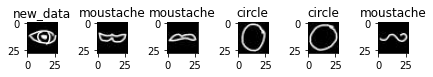

In [59]:
import matplotlib.pyplot as plt
image = [np.array(Image.open(new_data))]
name = ['new_data']
path = '/content/drive/MyDrive/Colab/Sketch_RNN_Together/Dataset/Filtered_img/'

for i in range(1, 6):
  idx = indices[0][i]
  image.append(np.array(Image.open(path + filename[idx].split('_')[0] + '/' + filename[idx] + '.jpg')))
  name.append(filename[idx].split('_')[0])


for i, img in enumerate(image):
  plt.subplot(1,6,i+1)
  plt.title(name[i])
  plt.imshow(img, 'gray')

plt.tight_layout()
plt.show()